### Going Deeper(CV)_DJ2

# 4. 이미지 어디까지 우려볼까?



> - 평가문항
>1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?
	- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.

>2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?
	- Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함

>3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?
	- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.








****************************************
! mkdir -p ~/aiffel/data_augmentation/data

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- stanford_dogs 데이터셋을 사용

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


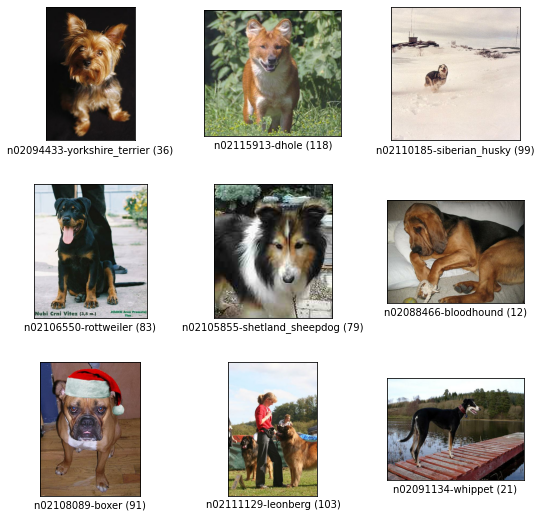

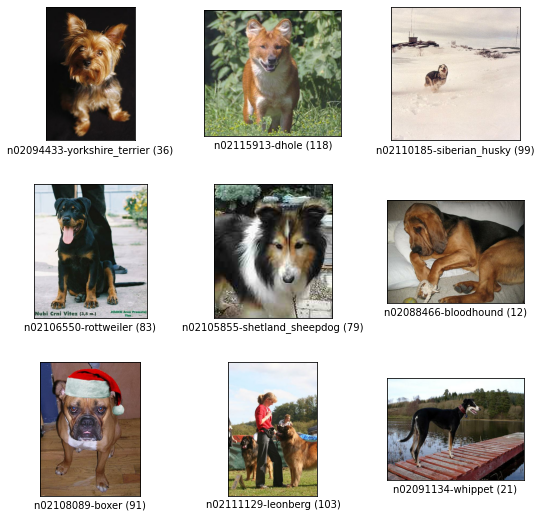

In [4]:
tfds.show_examples(ds_train, ds_info)

>기본적인 augmentation
>- random_brightness()
>- random_contrast()
>- random_crop()
>- random_flip_left_right()
>- random_flip_up_down()
>- random_hue()
>- random_jpeg_quality()
>- random_saturation()

In [11]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


In [12]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


In [13]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [14]:
# make random augment function
def augment2(image,label):
    # [[YOUR CODE]]
    image = tf.image.random_hue(image, np.random.uniform(0.50, 1.00))
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

In [15]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94773248/94765736 [==============================] - 1s 0us/step
=3


In [16]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [16]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 344s 424ms/step - loss: 3.1889 - accuracy: 0.2819 - val_loss: 3.2868 - val_accuracy: 0.2247
Epoch 2/20
750/750 [==============================] - 319s 425ms/step - loss: 0.9446 - accuracy: 0.7358 - val_loss: 1.2279 - val_accuracy: 0.6449
Epoch 3/20
750/750 [==============================] - 319s 425ms/step - loss: 0.3093 - accuracy: 0.9274 - val_loss: 1.0681 - val_accuracy: 0.6995
Epoch 4/20
750/750 [==============================] - 322s 430ms/step - loss: 0.0850 - accuracy: 0.9905 - val_loss: 0.9181 - val_accuracy: 0.7355
Epoch 5/20
750/750 [==============================] - 322s 430ms/step - loss: 0.0318 - accuracy: 0.9993 - val_loss: 0.9252 - val_accuracy: 0.7441
Epoch 6/20
750/750 [==============================] - 320s 427ms/step - loss: 0.0198 - accuracy: 0.9994 - val_loss: 0.9156 - val_accuracy: 0.7449
Epoch 7/20
750/750 [==============================] - 364s 485ms/step - loss: 0.0140 - accuracy: 0.9995 - val_loss: 0.9263 -

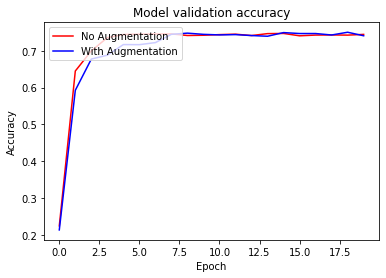

In [17]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

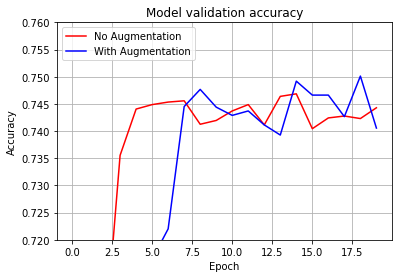

In [18]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

In [19]:
print(f"Augmentation X, CutMix X Data's best accuracy : {round(max(history_resnet50_no_aug.history['val_accuracy']), 3)}")
print(f"Augmentation O, CutMix X Data's best accuracy : {round(max(history_resnet50_aug.history['val_accuracy']), 3)}")

Augmentation X, CutMix X Data's best accuracy : 0.747
Augmentation O, CutMix X Data's best accuracy : 0.75


## 1. Augmentation을 적용한 데이터셋 만들기

In [18]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


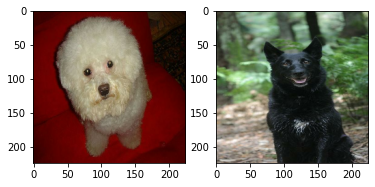

In [20]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [21]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [22]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(24, shape=(), dtype=int32) tf.Tensor(135, shape=(), dtype=int32) tf.Tensor(160, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


In [23]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

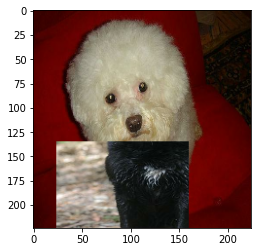

In [24]:
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

### 라벨 섞기

In [25]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [26]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [27]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

In [28]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [29]:
num_classes = ds_info.features["label"].num_classes

In [30]:
apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=False, with_cutmix=True)

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

## 2. 모델 만들기

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
batch_size = 16

es_3 = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
es_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
es = es_5

steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size)
validation_steps=int(ds_info.splits['test'].num_examples/batch_size)
epochs=20

In [32]:
num_classes = ds_info.features["label"].num_classes
num_classes
120

120

In [33]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=True,
)
ds_train_all = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [34]:
tf.random.set_seed(1994)

In [35]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 383s 441ms/step - loss: 4.6274 - accuracy: 0.0657 - val_loss: 3.6023 - val_accuracy: 0.1694
Epoch 2/20
750/750 [==============================] - 332s 443ms/step - loss: 3.3015 - accuracy: 0.3435 - val_loss: 1.4528 - val_accuracy: 0.6201
Epoch 3/20
750/750 [==============================] - 332s 442ms/step - loss: 2.9214 - accuracy: 0.4580 - val_loss: 1.1877 - val_accuracy: 0.6644
Epoch 4/20
750/750 [==============================] - 330s 441ms/step - loss: 2.6674 - accuracy: 0.5286 - val_loss: 1.0981 - val_accuracy: 0.6833
Epoch 5/20
750/750 [==============================] - 330s 440ms/step - loss: 2.4880 - accuracy: 0.5991 - val_loss: 1.1276 - val_accuracy: 0.6870
Epoch 6/20
750/750 [==============================] - 331s 441ms/step - loss: 2.3615 - accuracy: 0.6354 - val_loss: 1.0749 - val_accuracy: 0.6972
Epoch 7/20
750/750 [==============================] - 332s 443ms/step - loss: 2.2422 - accuracy: 0.6625 - val_loss: 1.0327 -

In [37]:
print(f"Augmentation X, CutMix O Data's best accuracy : {round(max(history_resnet50_cutmix.history['val_accuracy']), 3)}")

Augmentation X, CutMix O Data's best accuracy : 0.715


### Augmentation + CutMix

In [38]:
all_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [39]:
all_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_all = all_resnet50.fit(
    ds_train_all, 
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 345s 446ms/step - loss: 4.7343 - accuracy: 0.0457 - val_loss: 2.4756 - val_accuracy: 0.3597
Epoch 2/20
750/750 [==============================] - 332s 443ms/step - loss: 3.4994 - accuracy: 0.2892 - val_loss: 1.9585 - val_accuracy: 0.4647
Epoch 3/20
750/750 [==============================] - 330s 440ms/step - loss: 3.1323 - accuracy: 0.3832 - val_loss: 2.0153 - val_accuracy: 0.4712
Epoch 4/20
750/750 [==============================] - 331s 442ms/step - loss: 2.8794 - accuracy: 0.4628 - val_loss: 1.4805 - val_accuracy: 0.5875
Epoch 5/20
750/750 [==============================] - 329s 439ms/step - loss: 2.7577 - accuracy: 0.4876 - val_loss: 1.4676 - val_accuracy: 0.5991
Epoch 6/20
750/750 [==============================] - 331s 442ms/step - loss: 2.6530 - accuracy: 0.5278 - val_loss: 1.3529 - val_accuracy: 0.6251
Epoch 7/20
750/750 [==============================] - 329s 439ms/step - loss: 2.5445 - accuracy: 0.5614 - val_loss: 1.2348 -

In [69]:
print(f"Augmentation O, CutMix O Data's best accuracy : {round(max(history_resnet50_all.history['val_accuracy']), 3)}")

Augmentation O, CutMix O Data's best accuracy : 0.693


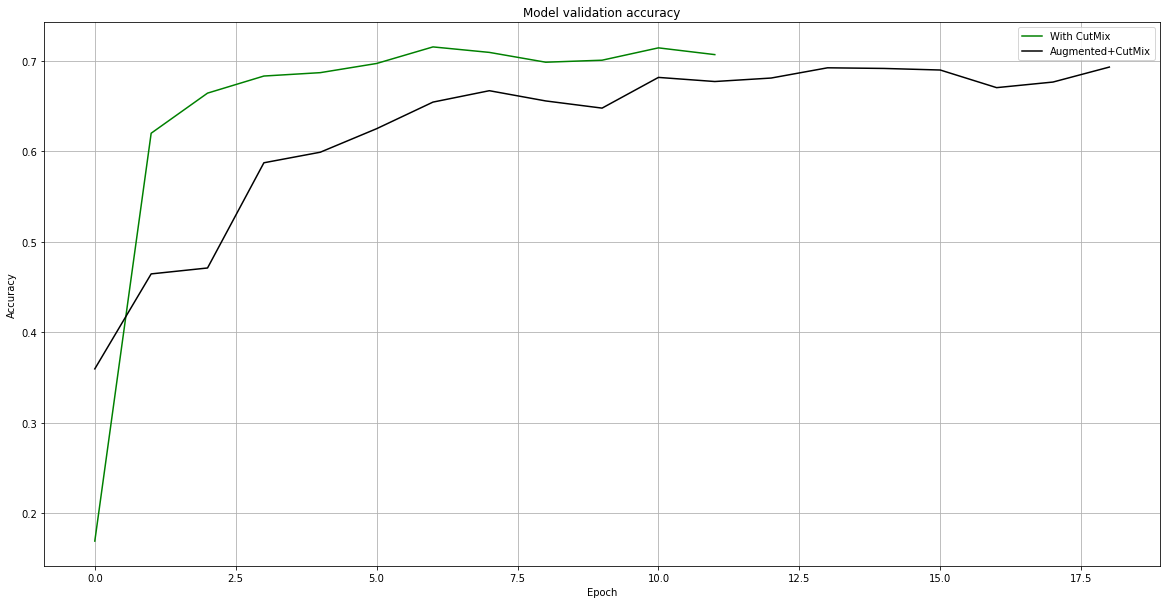

In [42]:
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_Accuracy.png')
plt.show()


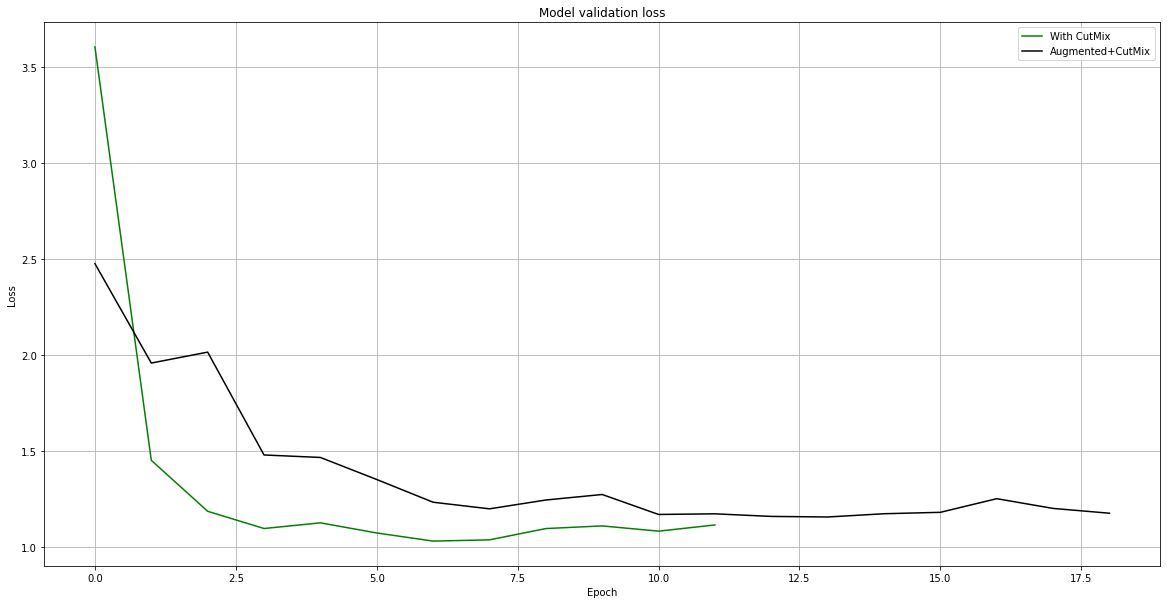

In [43]:
plt.figure(figsize=(20,10))
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_loss.png')
plt.show()

********************************************

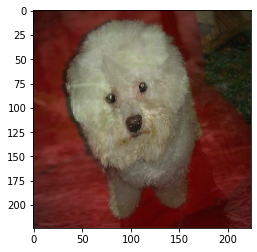

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.21956718 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [44]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [57]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [58]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [59]:
num_classes = ds_info.features["label"].num_classes

In [60]:
apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=False, with_mixup=True)

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [61]:
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
batch_size = 16

es_3 = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
es_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
es = es_5

steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size)
validation_steps=int(ds_info.splits['test'].num_examples/batch_size)
epochs=20

In [62]:
num_classes = ds_info.features["label"].num_classes
num_classes
120

120

In [63]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_all = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_mixup=True
    
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [64]:
tf.random.set_seed(1994)

In [65]:
mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [66]:
mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_mix_resnet50_all = mix_resnet50.fit(
    ds_train_all, 
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 341s 441ms/step - loss: 4.6708 - accuracy: 0.0597 - val_loss: 2.5927 - val_accuracy: 0.3539
Epoch 2/20
750/750 [==============================] - 340s 454ms/step - loss: 3.3644 - accuracy: 0.3222 - val_loss: 1.8680 - val_accuracy: 0.4987
Epoch 3/20
750/750 [==============================] - 329s 439ms/step - loss: 2.9722 - accuracy: 0.4410 - val_loss: 1.7157 - val_accuracy: 0.5368
Epoch 4/20
750/750 [==============================] - 330s 440ms/step - loss: 2.8295 - accuracy: 0.4979 - val_loss: 1.6693 - val_accuracy: 0.5532
Epoch 5/20
750/750 [==============================] - 328s 438ms/step - loss: 2.6858 - accuracy: 0.5466 - val_loss: 1.6004 - val_accuracy: 0.5718
Epoch 6/20
750/750 [==============================] - 328s 438ms/step - loss: 2.5563 - accuracy: 0.6042 - val_loss: 1.5764 - val_accuracy: 0.5802
Epoch 7/20
750/750 [==============================] - 328s 438ms/step - loss: 2.4515 - accuracy: 0.6444 - val_loss: 1.5041 -

In [68]:
print(f"Augmentation O, Mixup O Data's best accuracy : {round(max(history_mix_resnet50_all.history['val_accuracy']), 3)}")

Augmentation O, Mixup O Data's best accuracy : 0.646


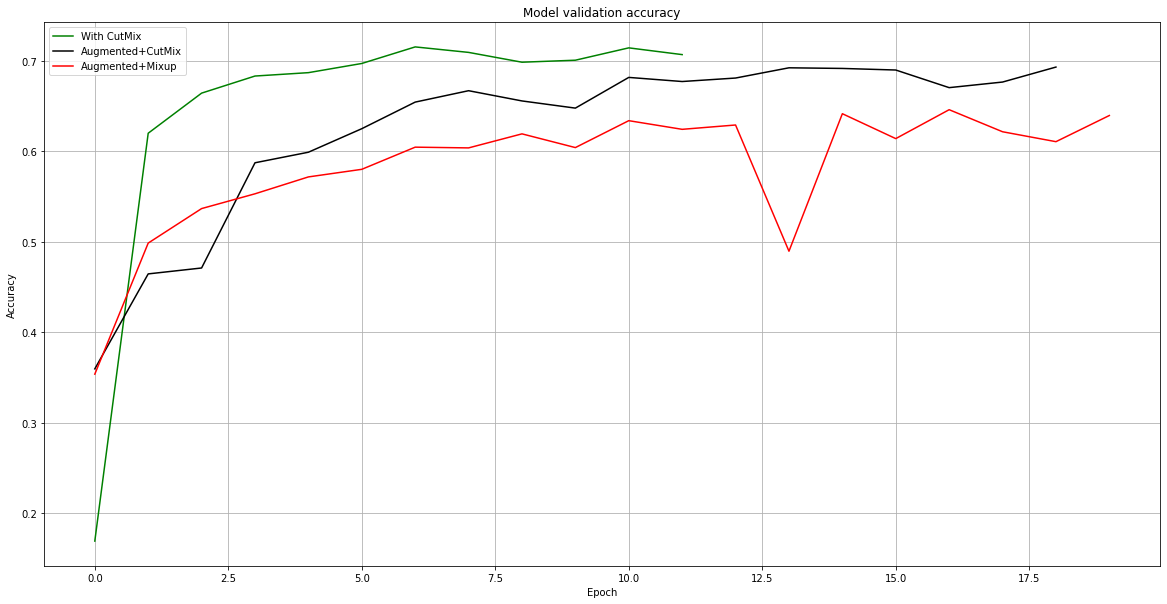

In [70]:
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.plot(history_mix_resnet50_all.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'Augmented+CutMix','Augmented+Mixup'], loc='best')
plt.grid(True)
plt.savefig('fig1_Accuracy.png')
plt.show()


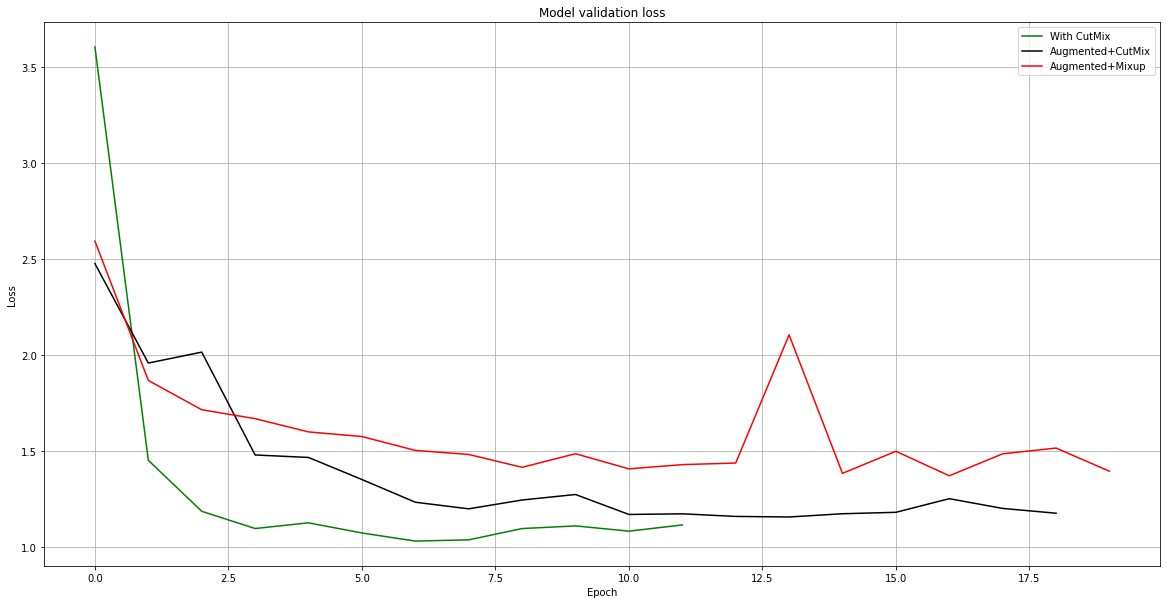

In [71]:
plt.figure(figsize=(20,10))
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.plot(history_mix_resnet50_all.history['val_loss'], 'r')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'Augmented+CutMix','Augmented+Mixup'], loc='best')
plt.grid(True)
plt.savefig('fig1_loss.png')
plt.show()

***********************
>결과
>- Augmentation X, CutMix X Data's best accuracy : 0.747
>- Augmentation O, CutMix X Data's best accuracy : 0.75
>- Augmentation X, CutMix O Data's best accuracy : 0.715
>- Augmentation O, CutMix O Data's best accuracy : 0.693
>- Augmentation O, Mixup O Data's best accuracy : 0.646



# 회고

- CutMix와 Mixup을 적용했을때 더 좋은 결과가 나와야 하는데 모델을 잘 못 했는지, 오히려 accuracy가 떨어졌다.....
- 조원 분들에게 미리 accuracy가 잘 오르지 않는다고는 들었다.
- 하지만 다른 블로그를 보면 다들 5퍼센트 이상은 올라갔다는데 왜 오르지 않는지 이유를 모르겠다.
- 그냥 Augmentation이 제일 좋고, Augmentation이 없는 CutMix가 Mixup에 비해 좋은 결과를 가진다.(시간이 없어서... **Mixup만 있는 모델을 하지 못했는데, 아마 합친 결과보다 더 좋게 나오지 않을까 싶다!**)
- Early stop을 해놨지만, 학습이 오래걸리는 편이라 많은 실험은 하지 못했다.
- categorical_crossentropy에 대해 한번 더 공부하는 기회가 되었다!